In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset from the Excel file
file_path_psp = '../data/raw/PSP_Jan_Feb_2019.xlsx'
file_path_fee = '../data/raw/PSP_Fees.xlsx'
file_path_processed_data = '../data/processed/PSP_model_data.xlsx'
df = pd.read_excel(file_path_psp)
df_fee = pd.read_excel(file_path_fee)

# Define attempts

* Definition:

In [34]:
# Sort the dataset by 'country', 'amount', 'PSP', and 'tmsp'
df_sorted = df.sort_values(by=['tmsp', 'country', 'amount', 'PSP']).reset_index(drop=True)

# Initialize an empty list to store the 'attempts' values
attempts = [1]  # The first row will always have an attempt value of 1

# Loop through the sorted DataFrame to calculate the 'attempts'
for i in range(1, len(df_sorted)):
    row = df_sorted.iloc[i]
    prev_row = df_sorted.iloc[i-1]

    # Check if 'country', 'amount', and 'PSP' are the same and 'tmsp' is within 60 seconds
    if (row['country'] == prev_row['country'] and
        row['amount'] == prev_row['amount'] and
        row['PSP'] == prev_row['PSP'] and
        (row['tmsp'] - prev_row['tmsp']).seconds < 60):
        attempts.append(attempts[-1] + 1)
    else:
        attempts.append(1)

# Add the 'attempts' column to the DataFrame
df_sorted['attempts'] = attempts

# Show the first few rows
df_sorted.head(10)

,index,tmsp,country,amount,success,PSP,3D_secured,card,attempts
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1
5,5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,1
6,6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,1
7,7,2019-01-01 00:08:46,Germany,117,1,UK_Card,0,Master,1
8,8,2019-01-01 00:09:56,Switzerland,174,0,Simplecard,0,Visa,1
9,9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa,2


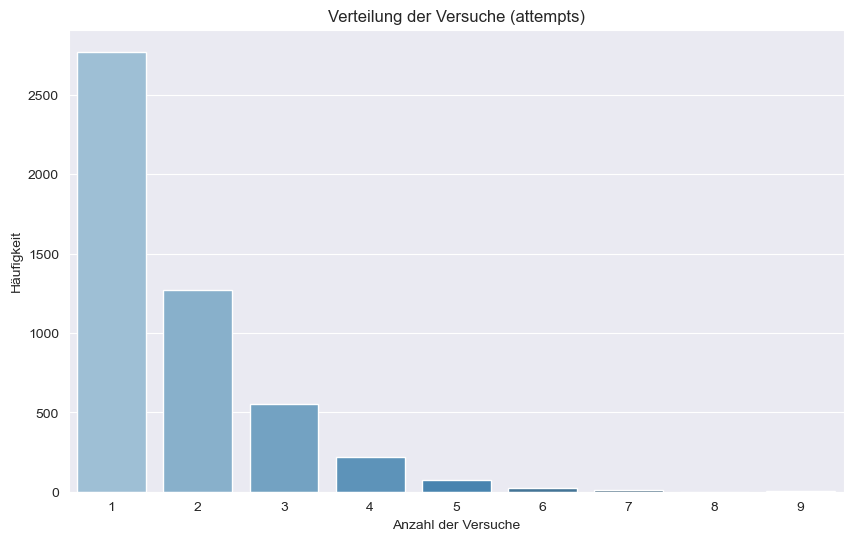

1    2772
2    1270
3     550
4     221
5      72
6      25
7       8
8       1
9       2
Name: attempts, dtype: int64

In [35]:
# Group the data by 'country', 'amount', 'PSP', and 'attempts' and count unique attempts
unique_attempts_count = df_sorted.groupby(['country', 'amount', 'PSP'])['attempts'].max().reset_index()
unique_attempts_distribution = unique_attempts_count['attempts'].value_counts().sort_index()

# Plot the distribution of 'attempts'
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_attempts_distribution.index, y=unique_attempts_distribution.values, palette="Blues_d")
plt.title('Verteilung der Versuche (attempts)')
plt.xlabel('Anzahl der Versuche')
plt.ylabel('Häufigkeit')
plt.show()

unique_attempts_distribution

In [36]:
# Merge the fees DataFrame with the original dataset based on 'PSP' and 'success'
df_merged = pd.merge(df_sorted, df_fee, on=['PSP', 'success'], how='left')

# Show the first few rows of the merged DataFrame to verify
df_merged.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,attempts,fee
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,1.0
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2,3.0
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,1.0
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,3.0
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5


# Time-related features

In [37]:
# Extract time-related features
df_merged['weekday'] = df_merged['tmsp'].dt.day_name()
df_merged['hour'] = df_merged['tmsp'].dt.hour

# Create time-of-day feature
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_merged['time_of_day'] = pd.cut(df_merged['hour'], bins=bins, labels=labels, right=False)

# Transactional features

In [38]:
# Create transaction-related features
df_merged['fee_to_amount_ratio'] = df_merged['fee'] / df_merged['amount']
df_merged['log_amount'] = np.log1p(df_merged['amount'])  # log1p is used to handle zero amounts

# Show the first few rows of the DataFrame to verify the new features
df_merged.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,attempts,fee,weekday,hour,time_of_day,fee_to_amount_ratio,log_amount
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,1.0,Tuesday,0,Night,0.011236,4.499810
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2,3.0,Tuesday,0,Night,0.033708,4.499810
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,1.0,Tuesday,0,Night,0.004202,5.476464
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,3.0,Tuesday,0,Night,0.012605,5.476464
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,Tuesday,0,Night,0.004032,4.828314


In [39]:
# Create interactive features
df_merged['country_PSP'] = df_merged['country'] + "_" + df_merged['PSP']
df_merged['PSP_3D_secured'] = df_merged['PSP'] + "_" + df_merged['3D_secured'].astype(str)

# Initialize columns for previous successes/failures and transaction duration
df_merged['previous_successes'] = 0
df_merged['previous_failures'] = 0
df_merged['transaction_duration'] = 0

# Loop through the DataFrame to calculate previous successes, previous failures, and transaction duration
# We only consider records that have 'attempts' greater than 1
groups = df_merged[df_merged['attempts'] > 1].groupby(['country', 'amount', 'PSP'])
for name, group in groups:
    success_count = 0
    failure_count = 0
    for i in range(len(group)):
        row = group.iloc[i]
        index = row.name
        if i == 0:
            # For the first record in the group, transaction duration is zero
            df_merged.at[index, 'transaction_duration'] = 0
        else:
            prev_row = group.iloc[i - 1]
            duration = (row['tmsp'] - prev_row['tmsp']).seconds
            df_merged.at[index, 'transaction_duration'] = duration

        if row['success'] == 1:
            success_count += 1
        else:
            failure_count += 1

        # Update the DataFrame with the accumulated counts
        df_merged.at[index, 'previous_successes'] = success_count
        df_merged.at[index, 'previous_failures'] = failure_count

# Show the first few rows of the DataFrame to verify the new features
df_merged[df_merged['attempts'] > 1].head()


,index,tmsp,country,amount,success,PSP,3D_secured,card,attempts,fee,weekday,hour,time_of_day,fee_to_amount_ratio,log_amount,country_PSP,PSP_3D_secured,previous_successes,previous_failures,transaction_duration
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2,3.0,Tuesday,0,Night,0.033708,4.499810,Germany_UK_Card,UK_Card_0,1,0,0
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,3.0,Tuesday,0,Night,0.012605,5.476464,Germany_UK_Card,UK_Card_1,1,0,0
9,9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa,2,0.5,Tuesday,0,Night,0.002874,5.164786,Switzerland_Simplecard,Simplecard_0,0,1,0
12,12,2019-01-01 00:13:34,Austria,232,0,UK_Card,1,Diners,2,1.0,Tuesday,0,Night,0.004310,5.451038,Austria_UK_Card,UK_Card_1,0,1,0
13,13,2019-01-01 00:13:44,Austria,232,0,UK_Card,1,Diners,3,1.0,Tuesday,0,Night,0.004310,5.451038,Austria_UK_Card,UK_Card_1,0,2,10


In [40]:
# Group the amount variable
df_merged['amount_group'] = pd.qcut(df['amount'], 3, labels=['small', 'medium', 'large'])

In [42]:
# Save data
df_merged.to_excel(file_path_processed_data, index=False)